# ---------------------------------------- HIVE PROJECT --------------------------------------

## Road Safety Data - Accidents 2018

#### Published by: Department for Transport 
#### Last updated: 26 September 2019 
#### Topic: Transport

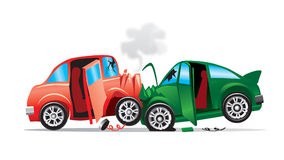

Source : https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data/datafile/36f1658e-b709-47e7-9f56-cca7aefeb8fe/preview

## LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

plt.style.use('ggplot')

In [2]:
from pyhive import hive

conn = hive.connect("quickstart.cloudera", username="cloudera")
cursor = conn.cursor()

### LOAD THE DATASET

In [3]:
dataset = pd.read_csv("car-accident.csv")#get the dataset

/home/cloudera/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#type of columns
dataset.dtypes

Accident_Index                                  object
Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                      int64
Junction_D

In [5]:
#The columns Date and Time are object type, so it is necessary to convert in timestamp to easy handle in hive

dataset['Date_Time'] =  dataset['Date'] + ' ' + dataset['Time']+':00' #we group the two columns to timestamp format
#we change the type to timestamp and create a new column Date_Time
dataset['Date_Time'] = pd.to_datetime(dataset['Date_Time'])
#Drop the colmuns Date and Time
dataset = dataset.drop(columns=['Date', 'Time'])
dataset.dtypes

Accident_Index                                         object
Location_Easting_OSGR                                 float64
Location_Northing_OSGR                                float64
Longitude                                             float64
Latitude                                              float64
Police_Force                                            int64
Accident_Severity                                       int64
Number_of_Vehicles                                      int64
Number_of_Casualties                                    int64
Day_of_Week                                             int64
Local_Authority_(District)                              int64
Local_Authority_(Highway)                              object
1st_Road_Class                                          int64
1st_Road_Number                                         int64
Road_Type                                               int64
Speed_limit                                             int64
Junction

In [6]:
#change some columns names to facilite the creation of the table with hive commands
dataset = dataset.rename(columns={'Location_Easting_OSGR':'Location_Easting', 
                        'Location_Northing_OSGR':'Location_Northing',
                        'Local_Authority_(District)':'Local_Authority_District',
                        'Local_Authority_(Highway)':'Local_Authority_Highway',
                        'Pedestrian_Crossing-Human_Control':'Pedestrian_Crossing_Human_Control',
                        'Pedestrian_Crossing-Physical_Facilities':'Pedestrian_Crossing_Physical_Facilities'})

### DATA CLEANING

In [8]:
#Verify of there are some missing values
data_NaN = dataset[dataset.isna().any(axis=1)]
data_NaN.to_csv("data_NaN.csv", index=None)

In [9]:
#There are approximately 6454 missing values in each columns without counting the LSOA.... column
#The total of missing values are: 6454

dataset = dataset.dropna(axis=0)#Delete all the missing values
dataset.to_csv("caraccident.csv", index=None)#Put the new result in a other CSV caraccident

In [10]:
cursor.execute('DROP DATABASE IF EXISTS ACCIDENT CASCADE') # if one was created before
cursor.execute('CREATE DATABASE ACCIDENT')

cursor.execute("CREATE TABLE IF NOT EXISTS ACCIDENT.caraccidents(\
Accident_Index STRING,\
Location_Easting FLOAT,\
Location_Northing FLOAT,\
Longitude FLOAT,\
Latitude FLOAT,\
Police_Force INT,\
Accident_Severity INT,\
Number_of_Vehicles INT,\
Number_of_Casualties INT,\
Day_of_Week INT,\
Local_Authority_District INT,\
Local_Authority_Highway STRING,\
1st_Road_Class INT,\
1st_Road_Number INT,\
Road_Type INT,\
Speed_limit INT,\
Junction_Detail INT,\
Junction_Control INT,\
2nd_Road_Class INT,\
2nd_Road_Number INT,\
Pedestrian_Crossing_Human_Control INT,\
Pedestrian_Crossing_Physical_Facilities INT,\
Light_Conditions INT,\
Weather_Conditions INT,\
Road_Surface_Conditions INT,\
Special_Conditions_at_Site INT,\
Carriageway_Hazards INT,\
Urban_or_Rural_Area INT,\
Did_Police_Officer_Attend_Scene_of_Accident INT,\
LSOA_of_Accident_Location STRING,\
Date_Time TIMESTAMP)\
ROW FORMAT DELIMITED \
FIELDS TERMINATED BY ','")

cursor.execute("LOAD DATA LOCAL INPATH '/home/cloudera/Documents/Project/caraccident.csv' OVERWRITE INTO TABLE ACCIDENT.caraccidents")
cursor.execute('ALTER TABLE ACCIDENT.caraccidents set \
TBLPROPERTIES ("skip.header.line.count"="1")')
               
cursor.execute('SET hive.cli.print.header=true') #To print the name of the variables

# DATA EXPLORATION

In [11]:
cursor.execute("use accident")

### A few methodes

In [82]:
def get_weekday(dt):
    return dt.weekday()

def get_dom(dt):
    return dt.day

def get_hour(dt):
    return dt.hour

def get_month(dt):
    return dt.month

"""data1['Month'] = data1['Date_Time'].map(get_month)
data1['Weekday'] = data1['Date_Time'].map(get_weekday)
data1['DOM'] = data1['Date_Time'].map(get_dom)
data1['Hour'] = data1['Date_Time'].map(get_hour)"""

"data1['Month'] = data1['Date_Time'].map(get_month)\ndata1['Weekday'] = data1['Date_Time'].map(get_weekday)\ndata1['DOM'] = data1['Date_Time'].map(get_dom)\ndata1['Hour'] = data1['Date_Time'].map(get_hour)"

In [13]:
cursor.execute('SELECT * FROM caraccidents')
query = cursor.fetchall()
data = pd.DataFrame(query, columns=(['Accident_Index', 'Location_Easting','Location_Northing',
                                    'Longitude','Latitude', 'Police_Force','Accident_Severity',
                                    'Number_of_Vehicles','Number_of_Casualties','Day_of_Week',
                                    'Local_Authority_District','Local_Authority_Highway',
                                    '1st_Road_Class','1st_Road_Number','Road_Type',
                                    'Speed_limit','Junction_Detail','Junction_Control',
                                    '2nd_Road_Class','2nd_Road_Number','Pedestrian_Crossing_Human_Control',
                                    'Pedestrian_Crossing_Physical_Facilities' ,'Light_Conditions',
                                    'Weather_Conditions','Road_Surface_Conditions',
                                    'Special_Conditions_at_Site','Carriageway_Hazards',
                                    'Urban_or_Rural_Area','Did_Police_Officer_Attend_Scene_of_Accident',
                                    'LSOA_of_Accident_Location','Date_Time']))

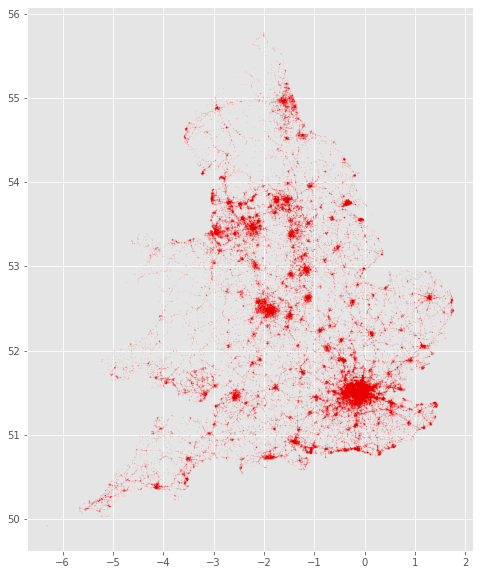

In [10]:
cursor.execute('SELECT Longitude, Latitude FROM caraccidents')
query = cursor.fetchall()
datalocation = pd.DataFrame(query, columns=('Longitude', 'Latitude'))
plt.rcParams["figure.figsize"] = (8,10)
figure = plt.scatter(datalocation['Longitude'], datalocation['Latitude'],c='red', alpha=0.05, s = 1)

In [11]:
cursor.execute('SELECT Day_of_Week, Accident_Severity, count(Accident_Severity) AS Number FROM caraccidents GROUP BY Day_of_Week, Accident_Severity')
query = cursor.fetchall()
data1 = pd.DataFrame(query, columns=('Day_of_Week', 'Accident_severity', 'Number'))


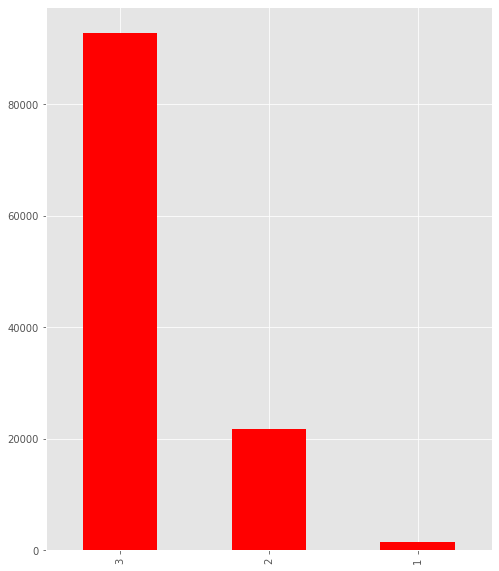

In [14]:
data['Accident_Severity'].value_counts().plot(kind='bar', color='red')
# there are more car accidents with the level 3 of intensity

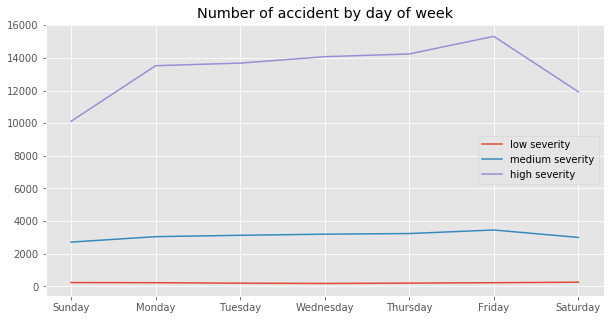

In [39]:
a, b, c = [], [], []
for i in range(data1.shape[0]):
    if (i in [0,3,6,9,12,15,18]):
        a.append(data1.at[i, 'Number'])
    if (i in [1,4,7,10,13,16,19]):
        b.append(data1.at[i, 'Number'])
    if (i in [2,5,8,11,14,17,20]):
        c.append(data1.at[i, 'Number'])

bins = list(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(bins, a, label='low severity')
plt.plot(bins, b, label='medium severity')
plt.plot(bins, c, label='high severity')
plt.legend()
plt.title('Number of accident by day of week')
plt.show()

### The interesting friday

In [75]:
cursor.execute('SELECT Date_Time, Accident_Severity, Longitude, Latitude, Urban_or_Rural_Area FROM caraccidents WHERE Day_of_Week = 6')
query = cursor.fetchall()
friday_data= pd.DataFrame(query, columns=(['Date_Time', 'Accident_Severity', 'Longitude', 'Latitude', 'Urban_or_Rural_Area']))

In [22]:
cursor.execute('SELECT Date_Time, Accident_Severity, count(Accident_Severity) AS Number FROM caraccidents GROUP BY Date_Time, Accident_Severity')
query = cursor.fetchall()
data2 = pd.DataFrame(query, columns=('Date_Time', 'Accident_severity', 'Number'))

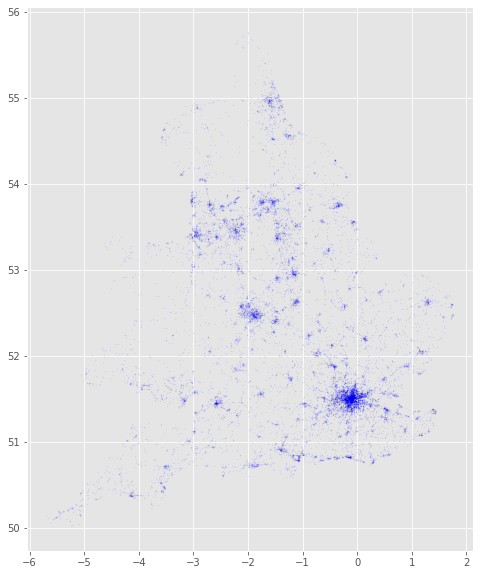

In [76]:
def get_month(dt):
    return dt.month

data2['Month'] = data2['Date_Time'].map(get_month)

plt.rcParams["figure.figsize"] = (8,10)
figure = plt.scatter(friday_data['Longitude'], friday_data['Latitude'],c='blue', alpha=0.05, s = 1)

In [86]:
cursor.execute('SELECT Date_Time, Accident_Severity, Longitude, Latitude, Urban_or_Rural_Area FROM caraccidents')
query = cursor.fetchall()
all_week_data= pd.DataFrame(query, columns=(['Date_Time', 'Accident_Severity', 'Longitude', 'Latitude', 'Urban_or_Rural_Area']))

In [87]:
GUorR = all_week_data.groupby('Urban_or_Rural_Area').count()
GU = GUorR.at[1,'Date_Time']/(GUorR.at[1,'Date_Time']+GUorR.at[2,'Date_Time'])
GR = GUorR.at[2,'Date_Time']/(GUorR.at[1,'Date_Time']+GUorR.at[2,'Date_Time'])

In [88]:
FUorR = friday_data.groupby('Urban_or_Rural_Area').count()
FU = FUorR.at[1,'Date_Time']/(FUorR.at[1,'Date_Time']+FUorR.at[2,'Date_Time'])
FR = FUorR.at[2,'Date_Time']/(FUorR.at[1,'Date_Time']+FUorR.at[2,'Date_Time'])
print('Friday urban :', FU, ', friday rural :', FR)

print('Global urban :', GU, ', global rural :', GR)

Friday urban : 0.680753644545024 , friday rural : 0.31924635545497604
Global urban : 0.6772708102013238 , global rural : 0.3227291897986762


In [42]:
data2.groupby(['Month', 'Accident_severity'], sort=True).count()

Date_Time  Number
Month Accident_severity                   
1     1                        128     128
      2                       1631    1631
      3                       6008    6008
2     1                        112     112
      2                       1415    1415
      3                       5279    5279
3     1                        119     119
      2                       1553    1553
      3                       5538    5538
4     1                        117     117
      2                       1698    1698
      3                       5571    5571
5     1                        134     134
      2                       1837    1837
      3                       6112    6112
6     1                        122     122
      2                       1876    1876
      3                       6152    6152
7     1                        126     126
      2                       1816    1816
      3                       5959    5959
8     1                        117     117
      2                       1634    1634
      3                       5613    5613
9     1                        144     144
      2                       1809    1809
      3                       6036    6036
10    1                        128     128
      2                       1777    1777
      3                       6104    6104
11    1                        135     135
      2                       1774    1774
      3                       6081    6081
12    1                        132     132
      2                       1621    1621
      3                       5572    5572

In [114]:
cursor.execute('SELECT Speed_limit, Accident_Severity, count(Accident_Severity) AS Number FROM caraccidents GROUP BY Speed_limit, Accident_Severity')
query = cursor.fetchall()
data3 = pd.DataFrame(query, columns=('Speed_limit', 'Accident_severity', 'Number'))

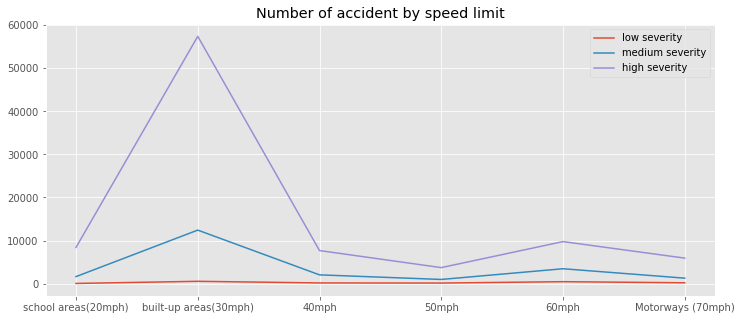

In [71]:
a, b, c = [], [], []
for i in range(data3.shape[0]):
    if (i in [0,3,6,9,12,15]):
        a.append(data3.at[i, 'Number'])
    if (i in [1,4,7,10,13,16]):
        b.append(data3.at[i, 'Number'])
    if (i in [2,5,8,11,14,17]):
        c.append(data3.at[i, 'Number'])

bins = list(['school areas(20mph)', 'built-up areas(30mph)', '40mph', '50mph', '60mph', 'Motorways (70mph)'])
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(bins, a, label='low severity')
plt.plot(bins, b, label='medium severity')
plt.plot(bins, c, label='high severity')
plt.legend()
plt.title('Number of accident by speed limit')
plt.show()

### About the month

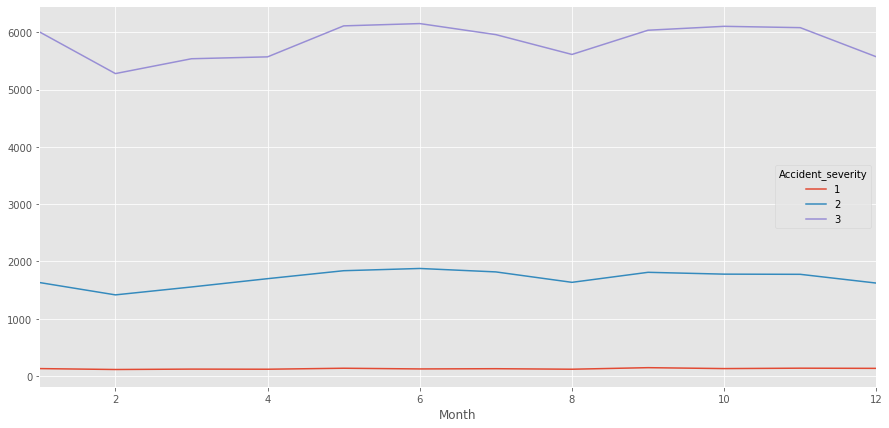

In [117]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
data2.groupby(['Month', 'Accident_severity'], sort=True).count()['Number'].unstack().plot( ax=ax)



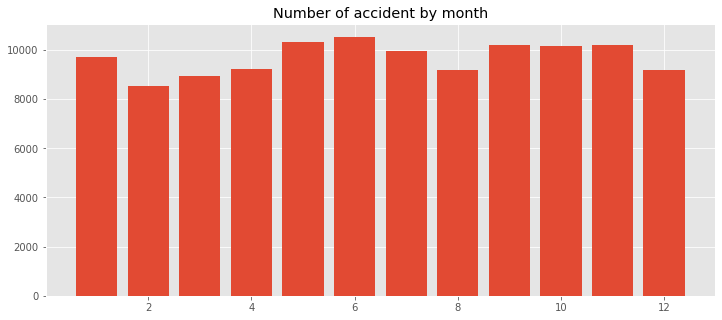

In [116]:
all_week_data['month'] = all_week_data['Date_Time'].map(get_month)

height = all_week_data['month'].groupby(all_week_data['month']).count()
plt.bar(range(1,13), height)
plt.title('Number of accident by month')
plt.show()

# Conclusion

Friday and built-up area are the placesand times where there are most of the accidents